In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt

import sys
sys.path.append("../../../")

from chiseling.dgps.kang_schafer_rct import KangSchaferRCT
from chiseling.source.learners.baselearners_general import make_random_forest_learner
from chiseling.source.protocol.IRST import UnitRegistrar, IRST
from chiseling.source.strategies.alpha_spending_strategy import AlphaSpendingStrategy
from chiseling.source.strategies.data_splitting_strategy import DataSplittingStrategy

In [3]:
# Hyperparameters
n = 500

alpha = 0.05

random_seed = 42

In [4]:
# Sample data
sampler = KangSchaferRCT(ipw_transform=True, random_seed=random_seed)
X, Y = sampler.sample(n)

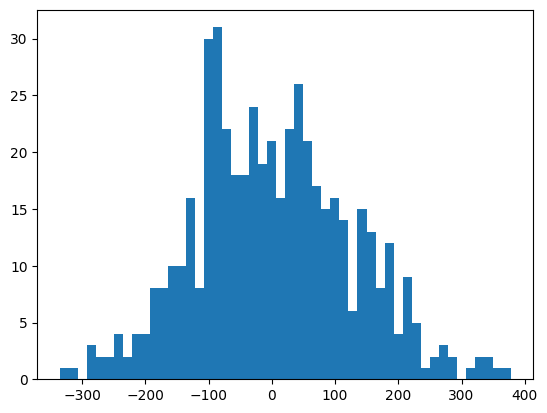

In [5]:
plt.hist(Y, bins=50)
plt.show()

In [6]:
sampler.get_optimal_region_metrics()

(np.float64(14.439398392469112),
 np.float64(0.49842),
 np.float64(28.970343069036378),
 np.float64(0.06707365058439946),
 np.float64(0.0015811309357545314),
 np.float64(0.09830438882591734))

In [7]:
# Initialize protocol
unit_reg = UnitRegistrar(random_seed)
regX = unit_reg.register_units(X)
protocol = IRST(regX, Y, alpha=alpha)

In [8]:
# Make random forest learner
rf_learner = make_random_forest_learner(random_seed=random_seed)

In [9]:
# Run chiseling
strategy = AlphaSpendingStrategy(protocol=protocol,
                                 test_thresh=0,
                                 learner=rf_learner,
                                 n_burn_in=0.2,
                                 batch_size=int(0.05 * n),
                                 n_min=2,
                                 alpha_min=0,
                                 alpha_spending_fn='instantaneous',
                                 tiebreak=False,
                                 use_learner_weights=False,
                                 skip_const_predictor=False,
                                 random_seed=random_seed)

strategy.run_strategy(verbose=True)

METRICS = {'curr_sample_efficiency': 1.0, 'spent_alpha': np.float64(0.0), 'remaining_alpha': np.float64(0.05), 'n_shrink_revealed': 170, 'n_left_in_region': 230, 'region_mass_estimate': np.float64(0.5750000000000001)}
SUMMARY: rejected = True, spent_alpha = 0.050000000000000044, n_left_in_region = 230, region_mass-estimate = 0.5750000000000001


In [10]:
protocol.testing_history

,stage_number,mean,variance,sample_size,test_stat,alloc_alpha,remaining_alpha,crit_val,rejection
0,-1,2.596670,15510.265315,500,0.466221,0.00,0.05,inf,False
1,0,2.596670,15510.265315,500,0.466221,0.00,0.05,inf,False
2,9,18.537613,16183.207961,230,2.209965,0.05,0.00,1.644854,True


In [11]:
# Run data splitting
datasplit = DataSplittingStrategy(X=X,
                                  Y=Y,
                                  train_ratio=0.2,
                                  learner=rf_learner,
                                  alpha=alpha,
                                  test_thresh=0,
                                  random_seed=random_seed)
datasplit.run_strategy()

In [12]:
# Data split rejection
datasplit.rejected

np.False_

In [13]:
# Chiseling region metrics
sampler.estimate_region_metrics(protocol.rejected_region)

(np.float64(10.896012876683496),
 np.float64(0.57555),
 np.float64(18.931479240176344),
 np.float64(0.07512009680803813),
 np.float64(0.001562984956741427),
 np.float64(0.11996692878505695))

In [14]:
# Data region metrics
sampler.estimate_region_metrics(datasplit.region)

(np.float64(8.833127473961625),
 np.float64(0.47709),
 np.float64(18.514593627956202),
 np.float64(0.06880485729399166),
 np.float64(0.001579478179336454),
 np.float64(0.1305436577884834))